In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy
from statsmodels.stats.weightstats import *

Загрузим данные о редитных историях клиентов одного из банков.

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv') #Выгружаем данные
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Поля в предоставляемых данных имеют следующий смысл: 
 
- **LIMIT_BAL**:  размер кредитного лимита (в том числе и на семью клиента)
- **SEX**: пол клиента (1 = мужской, 2 = женский )
- **EDUCATION**: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- **MARRIAGE**: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
- **AGE**: возраст в годах
- **PAY_0 - PAY_6** : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- **BILL_AMT1 - BILL_AMT6**:  задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
- **PAY_AMT1 - PAY_AMT6**: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
- **default** - индикатор невозврата денежных средств

### Пункт 1.

Проверим следующие гипотезы

1. О равенстве медианных значений кредитного лимита для людей вернувших/невернувших кредит  
2. О равенстве распределений для людей вернувших/невернувших кредит 

In [84]:
#Рассмотрим по отдельности данные о кредитных лимитах в двух группах
limit_0 = np.hstack(np.array(data[data['default'] == 0].loc[:, ['LIMIT_BAL']]))
limit_1 = np.hstack(np.array(data[data['default'] == 1].loc[:, ['LIMIT_BAL']]))

Рассмотрим полученные данные на графиках

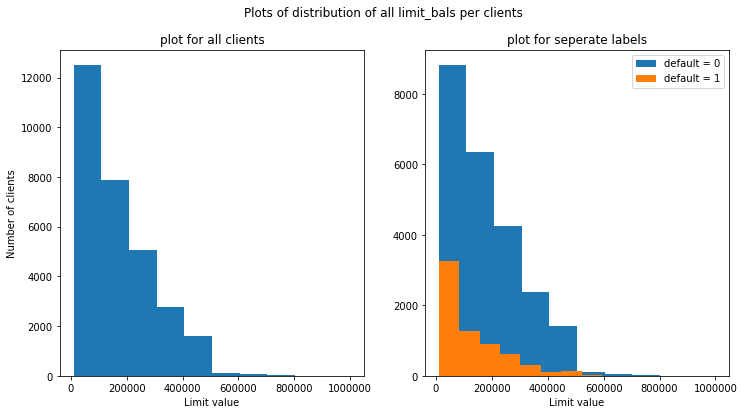

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Plots of distribution of all limit_bals per clients')
ax1.set_title('plot for all clients')
ax2.set_title('plot for seperate labels')
ax1.set_xlabel('Limit value')
ax1.set_ylabel('Number of clients')
ax2.set_xlabel('Limit value')
ax1.hist(data['LIMIT_BAL'])
ax2.hist(limit_0, label='default = 0')
ax2.hist(limit_1, label='default = 1')
ax2.legend()

Text(0.5, 1.0, 'Distribution of credit limits by default labels')

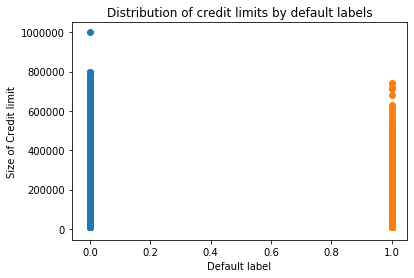

In [7]:
plt.scatter(np.zeros(len(limit_0)), limit_0)
plt.scatter([1 for i in range(len(limit_1))], limit_1)
plt.xlabel('Default label')
plt.ylabel('Size of Credit limit')
plt.title('Distribution of credit limits by default labels')

Теперь займемся проверкой гипотез:

Будем проверять медианную гипотезу двуборочным критерием Стюдента для незавсисимых выборок (поскольку, в каждая из выборок состовлена из уникальных клиентов, не связанных друг с другом)

Для это проверим нормальность выборок критерием Шапиро-Уилка и использую Q-Q plot.



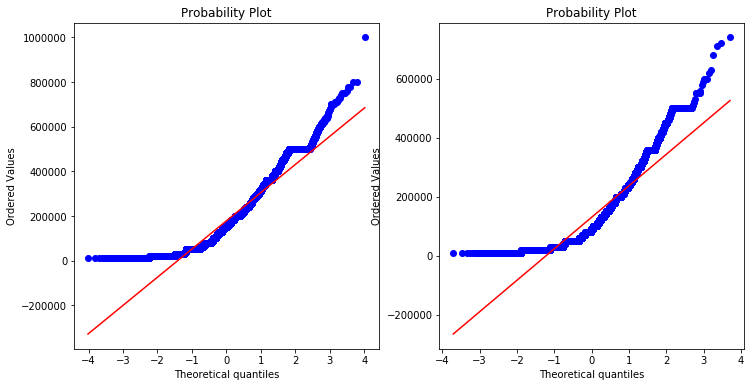

In [8]:
#Строим Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
res1 = stats.probplot(limit_0, dist="norm", plot=ax1)
res2 = stats.probplot(limit_1, dist="norm", plot=ax2)

Критерий Шапиро-Уилка:

 $H_0\colon$ способности к подавлению импульсивных реакций распредлены нормально
 
 $H_1\colon$ не нормально.

In [9]:
#Проверяем критерий Шапиро-Уилка через встроенную функцию библиотеки scipy.stats
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(limit_0))
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(limit_1))

Shapiro-Wilk normality test, W-statistic: 0.919726, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.854983, p-value: 0.000000


Как видно, p-value очень малы и мы можем отвегнуть гипотеза о нормальности наших выборок. Q-Q plot это также подтверждает (большая часть точек отдалена от прямой). Критерий Стьюдента применять нельзя.

Получается, что нужно применять другой критерий. Например, воспользуемся построением доверительных интервалов методом бутстрепа.

In [12]:
#Фунцкция для генерации псевдовыборок для бутстрепа
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [13]:
#Функция для построения интервала
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Медианы кредитного лимита равны в выборках клиентов вернувших и невернувших долг $H_{0}: \mu_{1} = \mu_{2}$ 

Против двусторонней альтернативы $H_{1}: \mu_{1} ≠ \mu_{2}$

In [82]:
limit0 = data[data['default'] == 0].loc[:, ['LIMIT_BAL']]
limit1 = data[data['default'] == 1].loc[:, ['LIMIT_BAL']]

limit0_bs = list(map(np.median, get_bootstrap_samples(limit0.values, 100)))
limit1_bs = list(map(np.median, get_bootstrap_samples(limit1.values, 100)))

print('Conf. interval for median of credit limits distirbution for default = 0 [%f,%f]' % (stat_intervals(limit0_bs, 0.05)[0], 
      stat_intervals(limit0_bs, 0.05)[1]))

print('Conf. interval for median of credit limits distirbution for default = 1 [%f,%f]' % (stat_intervals(limit1_bs, 0.05)[0], 
      stat_intervals(limit1_bs, 0.05)[1]))

Conf. interval for median of credit limits distirbution for default = 0 [150000.000000,150000.000000]
Conf. interval for median of credit limits distirbution for default = 1 [84750.000000,90000.000000]


95% доверительные интервалы для значений медиан в группах людей вернувших/невернувших кредит не пересекаются.

Теперь проверим еще одну гипотезу

$H_{0}$: Распределения кредитных лимитов в группах клиентов вернувших/невернувших кредит совпадают.

$H_{1}$: Против двусторонней альтернативы о несовпадении распределений

In [14]:
#Статистика перестановочного критерия
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [76]:
#Получаем рандомные перестановки
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [16]:
#Построение нулевого распределения
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [17]:
#Проверкаа гипотезы через перестановочный критерий
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

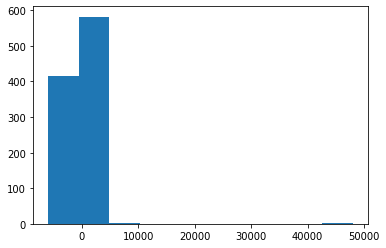

In [85]:
plt.hist(permutation_zero_dist_ind(limit_0, limit_1, max_combinations = 1000))
plt.show()

In [86]:
print('p-value: %f' % permutation_test(age0, age1, max_permutations=1000))

p-value: 0.019000


Гипотеза о равенстве распределений отвергается на уровне значимости 0.05. Результат значим с практической точки зрения, поскольку медианы в разных группах сильно отличаются друг от друга.

### Пункт 2.

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

In [18]:
#Извлекаем данные в соответствии с полом
data0 = data[data['default'] == 0]
data1 = data[data['default'] == 1]
men0 = data0[data0['SEX']==1].loc[:, ['SEX']]
women0 = data0[data0['SEX']==2].loc[:, ['SEX']]
men1 = data1[data1['SEX']==1].loc[:, ['SEX']]
women1 = data1[data1['SEX']==2].loc[:, ['SEX']]

Text(0.5, 0, 'Debt status')

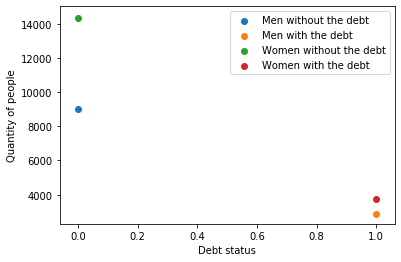

In [19]:
plt.scatter(0, len(men0), label="Men without the debt")
plt.scatter(1, len(men1), label="Men with the debt")
plt.scatter(0, len(women0), label="Women without the debt")
plt.scatter(1, len(women1), label="Women with the debt")
plt.legend()
plt.ylabel('Quantity of people')
plt.xlabel('Debt status')

По графику видно, что женщины чаще невозвращают кредит. Однако женщин в исходных данных больше.

Рассмотрим доверительные интервалы для долей, поскольку призанки бинарны и в обоих выборказ достаточное кол-во как нулей, так и едениц

In [20]:
#Строим бинарные выборки
data_men = np.concatenate((np.array([1 for i in range(len(men0))]), np.zeros(len(men1))), axis=None)
data_women = np.concatenate((np.array([1 for i in range(len(women0))]), np.zeros(len(women1))), axis=None)

In [21]:
#Считаем медиану
men_med = men1.shape[0]/data_men.shape[0]*100
wo_med = women1.shape[0]/data_women.shape[0]*100
delta = (men_med-wo_med)
print('Average percent of men without debt', men_med, '%')
print('Average percent of women without debt', wo_med, '%')
print('Difference beetween percents : %.4f' % delta, '%')

Average percent of men without debt 24.16722745625841 %
Average percent of women without debt 20.776280918727917 %
Difference beetween percents : 3.3909 %


In [22]:
from statsmodels.stats.proportion import proportion_confint
#И доверительный интервал для доли с помощью proportion_confint из библиотеки statsmodels


print('Conf. int. for prop. of men : [%.4f, %.4f]' % proportion_confint(men0.shape[0], data_men.shape[0]))
print('Conf. int. for prop. of women : [%.4f, %.4f]' % proportion_confint(women0.shape[0], data_women.shape[0]))

Conf. int. for prop. of men : [0.7506, 0.7660]
Conf. int. for prop. of women : [0.7863, 0.7981]


Как видно, доверительные интервалы не пересекаются. Процент женщин невернувших кредит меньше в среднем на 3.39%, что на практике значительно, так как у банка сотни тысяч, если не миллионы клиентов.

Проверим эту гипотезу строго, использя z-критерий для доли. Выборка опять же независимая.

$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

Таким образом наша гипотеза

Гендерный состав не отличается между двумя группами не отличается $H_0\colon$ $p_{1} = p_{2}$
 
Против двусторонней альтернативы о различаях между гендерным составом $H_1\colon$ $p_{1} ≠ p_{2}$

In [23]:
#Доверительный интервал для двух долей (несвязанные выборки)
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

#Статитстика для двух долей
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

#Проверка гипотезы для долей
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [24]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(data_women, data_men))

95% confidence interval for a difference between proportions: [0.024207, 0.043612]


In [25]:
print('p-value:',proportions_diff_z_test(proportions_diff_z_stat_ind(data_men, data_women)))

p-value: 4.472866521609831e-12


**Вывод:** Как мы видим, гипотезы о равенстве составов смело отвергается с достигаемым уровнем значимости **p_value = 4.47e-12** на уровне значимости 0.05.

Доверительный интервал для разности долей не содержит нуль, что тоже подтверждает различие между группами в 3%. Опять же результат практически значим, о чем было сказано раннее.

### Пункт 3.

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.

In [26]:
#Извлекаем данные
edu = data.EDUCATION
edu0 = data[data['default']==0].EDUCATION
edu1 = data[data['default']==1].EDUCATION

Text(0.5, 0, 'Education')

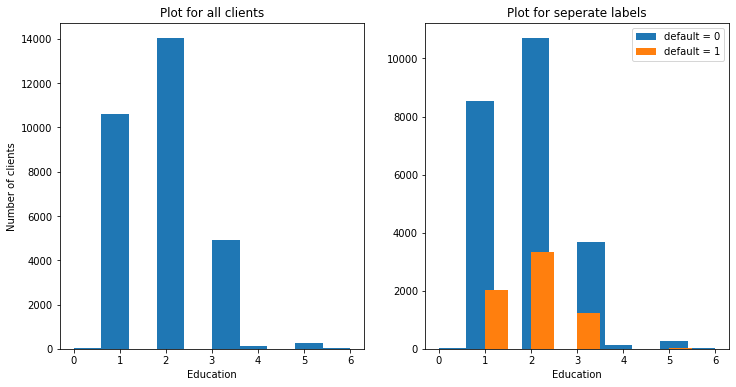

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(edu)
ax2.hist(edu0, label='default = 0')
ax2.hist(edu1, label='default = 1')
ax2.legend()
ax1.set_title('Plot for all clients')
ax2.set_title('Plot for seperate labels')
ax1.set_xlabel('Education')
ax1.set_ylabel('Number of clients')
ax2.set_xlabel('Education')

Cоставим таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.

Для начала вычислим процент вернувших долг

expected value = 0.862953


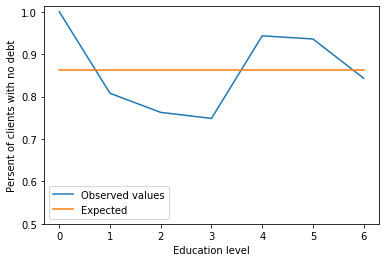

In [109]:
#Рассмотрим различие между реальными и ожидаемыми значениями
percent = []
for i in range(7):
    percent.append(sum(np.where(edu0 == i, 1, 0))/sum(np.where(edu == i, 1, 0)))

expected_value = np.mean(percent)
print('expected value = %f' % expected_value)


plt.plot(np.arange(0,7,1), percent, label = 'Observed values')
plt.plot(np.arange(0,7,1), [expected_value for i in range(7)], label = 'Expected')
plt.xlabel('Education level')
plt.ylabel('Persent of clients with no debt')
plt.ylim(0.5)
plt.legend()

Видно, что в среднем по всей выборке ожидаемый уровень возврата состовляет почти 87%. Клиенты с уровнем образования - "доктор" вернули все кредиты (хотя, возможно, это из-за того что в выборке почти нет людей с таким уровнем образования). Кроме того большую часть кредитов вернули люди без образования.

Построим таблицу сопряженности, где в столбцах будут люди вернувшие долг (с поправкой на ожидаемую величину), а по строкам уровень образовния :

In [99]:
#Получаем таблиц сопряженности
table = np.eye(7,2)
for i in range(7):
    table[i][0] = sum(np.where(edu0 == i, 1, 0))
    table[i][1] = expected_value*sum(np.where(edu0 == i, 1, 0))
                                                                           
table_df = pd.DataFrame(table, index=np.arange(7), columns=['Observed', 'Expected'])
table_df

,Observed,Expected
0,14.0,12.081337
1,8549.0,7377.382274
2,10700.0,9233.593441
3,3680.0,3175.665782
4,116.0,100.102508
5,262.0,226.093596
6,43.0,37.106964


Итого - проверяемая гипотеза такова:

$H_{0}$: образование не влияет на вероятность выплаты долга (т.е. образование имеет нормальное распределение и влияние случайно)

$H_{1}$: против двусторонней альтернативы - образование влияет

Будем пользоваться критерием хи-квадрат, но для начала проверим его применимость


In [100]:
#Функция проверки критерия хи-квадрат
def chi2_check(DataFrame, table):
    error_number = 0
    sum_obs = DataFrame.sum(axis=0)[0]
    sum_exp = DataFrame.sum(axis=0)[1]
    all_sum = np.sum(table)
    for i in range(len(table)):
        if (np.sum(table[i]) + sum_obs)/all_sum < 5:
            error_number += 1
        if (np.sum(table[i]) + sum_exp)/all_sum < 5:
            error_number += 1
    return (error_number/DataFrame.size < 0.2 and  all_sum > 40)

In [102]:
if chi2_check(table_df, table) == True:
    print('Критерий применим')
else:
    print('Критерий неприменим')

Критерий неприменим


Однако, всё равно посмотрим на значение p-value при применении критерия

In [103]:
#Проверяем гипотезу через хи-квадрат
chi2, p = stats.chisquare(table_df.Observed, table_df.Expected)
print('p-value:', p)

p-value: 1.2327831491855004e-106


**Вывод:** Как видно, достигаемый уровень значимости ничтожно мал (**p_value = 1.23e-106**) и мы смело можем отвергнуть гипотезу о том что выплата долга не зависит от образования.

Из графика выше, как было сказано раннее видно, какие люди реже выплачивают долг. Однако, если посмтореть на данные, видно, что большая доля выплаченых кредитов выпадает на довольно малые группы, так что трудно судить о практической значимости результата относительно этих групп. Кроме того, не выполнялись условия применимости критерия хи-квадрат.

### Пункт 4.

Проверим, как связан семейный статус с индикатором дефолта. Есть ли между ними какая-либо связь.

Для это мы можем воспользоваться коэффициентом V Крамера.

Text(0.5, 0, 'Mariage status')

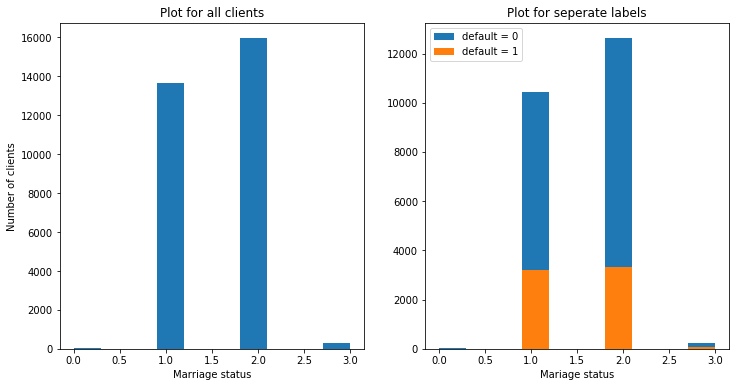

In [32]:
#Извлекаем данные
marr = data.MARRIAGE
marr0 = data[data['default']==0].MARRIAGE
marr1 = data[data['default']==1].MARRIAGE

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(marr)
ax2.hist(marr0, label='default = 0')
ax2.hist(marr1, label='default = 1')
ax2.legend()
ax1.set_title('Plot for all clients')
ax2.set_title('Plot for seperate labels')
ax1.set_xlabel('Marriage status')
ax1.set_ylabel('Number of clients')
ax2.set_xlabel('Mariage status')

In [104]:
#Получаем таблицу сопряженности
table_marr = np.eye(4,2)
for i in range(4):
    table_marr[i][0] = sum(np.where(marr0 == i, 1, 0))
    table_marr[i][1] = sum(np.where(marr1 == i, 1, 0))
    
marr_df = pd.DataFrame(table_marr, index=np.arange(4), columns=['Default = 0', 'Default = 1'])
marr_df

,Default = 0,Default = 1
0,49.0,5.0
1,10453.0,3206.0
2,12623.0,3341.0
3,239.0,84.0


Для использования коэффициента V Крамера требуется проверить применимость критерия хи-квадрат

In [105]:
#Проверяем критерий хи-квадрат
if chi2_check(table_df, table) == True:
    print('Критерий применим')
else:
    print('Критерий неприменим')

Критерий неприменим


Однако всё равно посчитаем коэффициент

In [ ]:
#Рассчитываем коэффициент Крамера
chi2 = stats.chi2_contingency(table_marr)[0]
kramer = np.sqrt(chi2/(3*(len(marr0)+len(marr1))))
print('V Kramer coeff %f' % kramer)

**Вывод:** Взаимосвязь практически отсутствует так коэффициент V Крамера практически равен нулю (**V_Kramer = 0.02**). Таким образом, взаимосвязь между факторами "семейное положение"/"возврат долга" отсутствует. Однако мы не можем об этом говорить однозначно. Критерий хи-квадрат неприменим с одной стороны, но и с другой стороны, распределения показывают, что для всех групп процент вернувших кредит примерно одинаков.

### Пункт 5.

Теперь проверим гипотезы относительно двух групп людей  вернувших и не вернувших кредит
1. о равенстве медианных значений возрастов людей 
2. о равенстве распределений

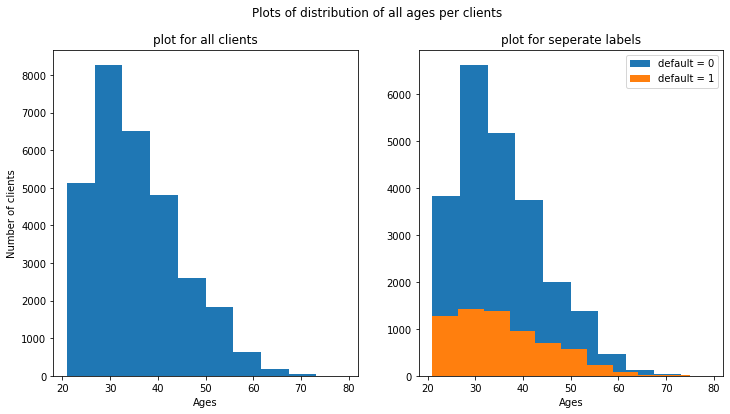

In [34]:
#Извлекаем данные
age0 = np.hstack(np.array(data[data['default'] == 0].loc[:, ['AGE']]))
age1 = np.hstack(np.array(data[data['default'] == 1].loc[:, ['AGE']]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Plots of distribution of all ages per clients')
ax1.set_title('plot for all clients')
ax2.set_title('plot for seperate labels')
ax1.set_xlabel('Ages')
ax1.set_ylabel('Number of clients')
ax2.set_xlabel('Ages')
ax1.hist(data['AGE'])
ax2.hist(age0, label='default = 0')
ax2.hist(age1, label='default = 1')
ax2.legend()

Проверяем следующую гипотезу

$H_{0}$: Медианы распределений возраста для выборки клиентов вернувших/невернувших долг совпадают

$H_{1}$: Против двусторонней альтернативы о несовпадении

In [35]:
#Считаем медианы
print('Median in age distirbution for default = 0 %f' % np.median(age0))
print('Median in age distirbution for default = 1 %f' % np.median(age1))

Median in age distirbution for default = 0 34.000000
Median in age distirbution for default = 1 34.000000


Медианы совпали. Построем доверительный интервал, для медиан и их разности на основе бутстрепа.

In [55]:
#Сравниваем медианы интервально (через бутстреп)
age0 = data[data['default'] == 0].loc[:, ['AGE']]
age1 = data[data['default'] == 1].loc[:, ['AGE']]

age0_bs = list(map(np.median, get_bootstrap_samples(age0.values, 100)))
age1_bs = list(map(np.median, get_bootstrap_samples(age1.values, 100)))

print('Conf. interval for median of age distirbution for default = 0 [%f,%f]' % (stat_intervals(age0_bs, 0.05)[0], 
      stat_intervals(age0_bs, 0.05)[1]))
print('Conf. interval for median of age distirbution for default = 1 [%f,%f]' % (stat_intervals(age1_bs, 0.05)[0], 
     stat_intervals(age1_bs, 0.05)[1]))

Conf. interval for median of age distirbution for default = 0 [34.000000,34.000000]
Conf. interval for median of age distirbution for default = 1 [34.000000,35.000000]


In [37]:
delta_med = np.median(age0) - np.median(age1)
print('Difference in medians = %f' % delta_med)

Difference in medians = 0.000000


In [38]:
#И сравниваем интервально медианы разности
delta_med_list = list(map(lambda x,y: x-y, age0_bs, age1_bs))
print('95 percent  Conf. int. for median difference [%f, %f]' % (stat_intervals(delta_med_list, 0.05)[0], 
                                                          stat_intervals(delta_med_list, 0.05)[1]))

95 percent  Conf. int. for median difference [-1.000000, 0.000000]


**Вывод:** Как видно, доверительные интервалы для медиан пересекаются и доверительный интервал для разности медиан содержит нуль, следовательно мы можем принять гипотезу о равенстве медиан возрастов в группах клиентов вернувших/невернувших долг. Этот результат представляет практическую значимость - вероятность возврата кредита не зависит от возраста клиента.

Теперь проверим еще одну гипотезу

$H_{0}$: Распределения возрастов в группах клиентов вернувших/невернувших кредит совпадают.

$H_{1}$: Против двусторонней альтернативы о несовпадении распределений

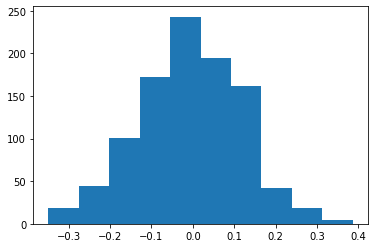

In [77]:
age0 = np.hstack(np.array(data[data['default'] == 0].loc[:, ['AGE']]))
age1 = np.hstack(np.array(data[data['default'] == 1].loc[:, ['AGE']]))

plt.hist(permutation_zero_dist_ind(age0, age1, max_combinations = 1000))
plt.show()

In [78]:
#Проверяем перестановочным критерием гипотезу (функции выше)
print('p-value: %f' % permutation_test(age0, age1, max_permutations=1000))

p-value: 0.013000


Гипотеза о совпадении распределений отвергается на уровне значимости 0.05. 

Как мы видим, результат может быть значим практически, потому что на распределении видно, что люди от 20-30 менее склонны отдавать кредит, чем люди из возрастной группы (30-50). Хотя при этом медианы равны, что не показывает разности в распределениях (когда она присутствует)